In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
IMG_SIZE = 128     # resize all images
MAX_IMAGES = 500

dataset_path = "/content/drive/MyDrive/food_calorie_project/coin dataset/JPEGImages"
all_images = os.listdir(dataset_path)

# Shuffle & select
random.shuffle(all_images)
selected_images = all_images[:MAX_IMAGES]


In [ ]:
X_gray = []
Y_rgb  = []

for img_name in selected_images:
    img_path = os.path.join(dataset_path, img_name)

    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Normalize
    gray = gray / 255.0
    img  = img / 255.0

    X_gray.append(gray)
    Y_rgb.append(img)

X_gray = np.array(X_gray).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_rgb  = np.array(Y_rgb)


In [ ]:
print(X_gray.shape)  # (N, 128, 128, 1)
print(Y_rgb.shape)   # (N, 128, 128, 3)


(500, 128, 128, 1)
(500, 128, 128, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X_gray, Y_rgb, test_size=0.2, random_state=42
)


In [ ]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

# -------- Encoder --------
x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

# -------- Decoder --------
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

output_img = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

model = Model(input_img, output_img)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,603 (1.14 MB)

 Trainable params: 297,603 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, Y_val)
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0505 - val_loss: 0.0127
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - loss: 0.0105 - val_loss: 0.0069
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.0067 - val_loss: 0.0060
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.0065 - val_loss: 0.0055
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - loss: 0.0053 - val_loss: 0.0050
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.0050 - val_loss: 0.0048
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.0049 - val_loss: 0.0044
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.0048 - val_loss: 0.0043
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 0.0044 - val_loss: 0.0042
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 0.0040 - 

In [ ]:
predicted_rgb = model.predict(X_val)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [ ]:
print("Final Validation MSE:", history.history['val_loss'][-1])


Final Validation MSE: 0.003971072379499674


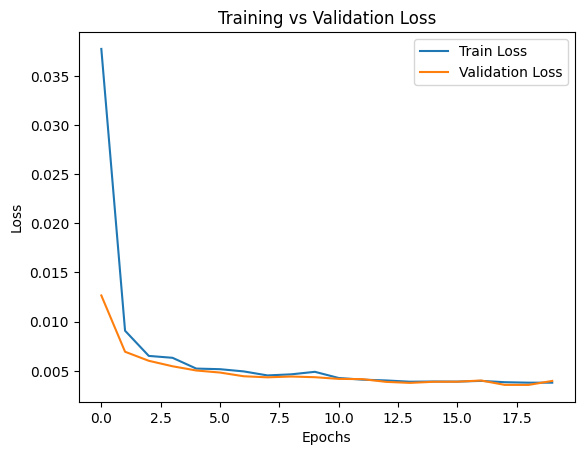

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


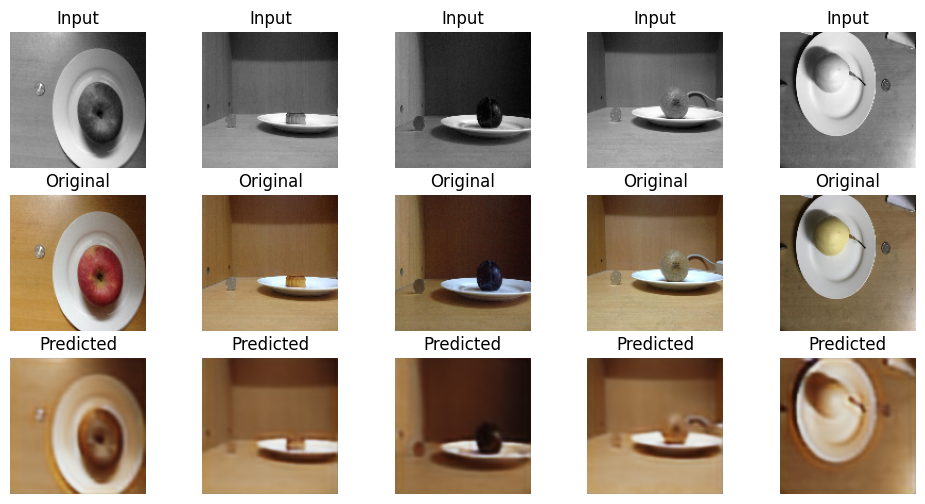

In [13]:
preds = model.predict(X_val[:5])

plt.figure(figsize=(12,6))

for i in range(5):
    # Grayscale
    ax = plt.subplot(3,5,i+1)
    plt.imshow(X_val[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title("Input")
    plt.axis("off")

    # Original
    ax = plt.subplot(3,5,i+1+5)
    plt.imshow(Y_val[i])
    plt.title("Original")
    plt.axis("off")

    # Predicted
    ax = plt.subplot(3,5,i+1+10)
    plt.imshow(preds[i])
    plt.title("Predicted")
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


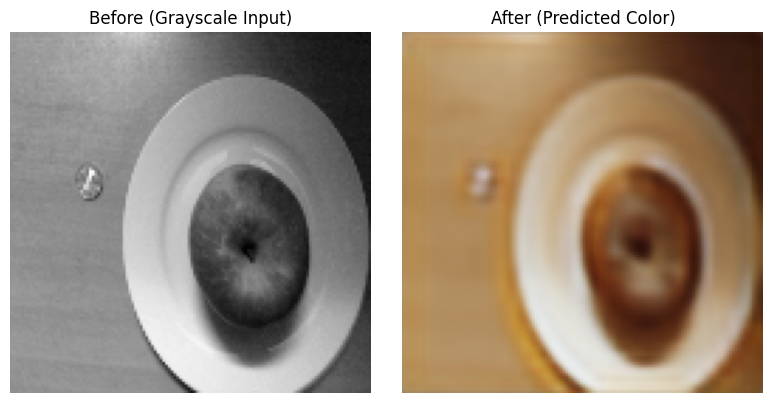

In [14]:
# Predict one image
pred = model.predict(X_val[0:1])

plt.figure(figsize=(8,4))

# Before (Grayscale Input)
plt.subplot(1,2,1)
plt.imshow(X_val[0].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
plt.title("Before (Grayscale Input)")
plt.axis("off")

# After (Predicted Color)
plt.subplot(1,2,2)
plt.imshow(pred[0])
plt.title("After (Predicted Color)")
plt.axis("off")

plt.tight_layout()
plt.show()
